# Dissecting Spotify Valence

In this assignment we will dissect Spotify's Valence metric.

---

> Chalkiopoulos Georgios, Electrical and Computer Engineer NTUA <br />
> Data Science postgraduate Student <br />
> gchalkiopoulos@aueb.gr

Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

Our task is to untangle the mystery behind valence and propose how this is derived.

Spotify offers the following information, relevant to our task:

* [Get Track's Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) and [Get Tracks' Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

* [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis).


### Setting up the Spotify API*

\* The section in this part uses code from the Course "Practical Data Science" performed in the MSc Data Science program at AUEB by prof. Panos Louridas

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime
import os
from itertools import combinations

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

%matplotlib inline

#### Download the top-streaming songs of the 2017-2019 period

We would like to explore the top-streaming apps in Spotify around the world which are provided by Spotify Charts.

Unfortunately, although the data are downloadble in CVS format, we cannot scrape them as access to them is guarded by CloudFare. Fortunately, data for some countries and the world as a whole, for the period 2017-2019, is available in Zenodo https://doi.org/10.5281/zenodo.4778562:

  * Gabriel P. Oliveira, Mariana O. Silva, Danilo B. Seufitelli, Anisio Lacerda, and Mirella M. Moro. Detecting Collaboration Profiles in Success-based Music Genre Networks. In Proceedings of the 21st International Society for Music Information Retrieval Conference (ISMIR 2020), 2020.
We'll download the charts data (charts.zip).

After downloading it places data for each region in per-year directories. In each one of these, charts are given in weekly files, so we'll read all for them and record the week and region.

In [2]:
header = 0
dfs = []
for file in glob.glob('../Charts/*/201?/*.csv'):
    region = file.split('/')[1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
196,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
197,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
198,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...


* There are tens of thousands of songs in the charts, but not all of them are unique:

In [3]:
len(all_charts['song_id'].unique())

13880

* For storing our credentials, we'll create a file spotify_config.py with the following contents:

In [4]:
config = {
    'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
}

* Then we can create a Spotify client.

In [5]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [6]:
features = {}
all_track_ids = list(all_charts['song_id'].unique())

In [7]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

* Let's verify that we got all of them and see how one looks.

In [8]:
len(features)

13880

In [9]:
features['7qiZfU4dY1lWllzX7mPBI3']

{'danceability': 0.825,
 'energy': 0.652,
 'key': 1,
 'loudness': -3.183,
 'mode': 0,
 'speechiness': 0.0802,
 'acousticness': 0.581,
 'instrumentalness': 0,
 'liveness': 0.0931,
 'valence': 0.931,
 'tempo': 95.977,
 'type': 'audio_features',
 'id': '7qiZfU4dY1lWllzX7mPBI3',
 'uri': 'spotify:track:7qiZfU4dY1lWllzX7mPBI3',
 'track_href': 'https://api.spotify.com/v1/tracks/7qiZfU4dY1lWllzX7mPBI3',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7qiZfU4dY1lWllzX7mPBI3',
 'duration_ms': 233713,
 'time_signature': 4}

* Spotify also offers the [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis) API. In order to see if there is any usefull info, we looked through the response example and concluded that the `track` part of the response might have some usefull info. Let's see what parts of the track are not available in the `audio_features` API

In [10]:
for key in sp.audio_analysis('5aAx2yezTd8zXrkmtKl66Z')['track']:
    if key not in features['5aAx2yezTd8zXrkmtKl66Z'].keys():
        print(key)

num_samples
duration
sample_md5
offset_seconds
window_seconds
analysis_sample_rate
analysis_channels
end_of_fade_in
start_of_fade_out
tempo_confidence
time_signature_confidence
key_confidence
mode_confidence
codestring
code_version
echoprintstring
echoprint_version
synchstring
synch_version
rhythmstring
rhythm_version


* Based on the columns available we will skip the `audio_features` for now since it seems that the info is not usefull for our analysis.

# Section 1: Expore which Track Features Influence Valence

We will use inferential statistic methods to study how track features influence valence. We will find the best possible model for explaining the valence based on the features that we find significant.

* We'll turn the dictionary to a DataFrame.

In [169]:
# create df, reset index (since the song id is currently index) and rename to song_id
try:
    df = pd.DataFrame.from_dict(features, orient='index').reset_index().rename(columns={'index': 'song_id'})
    df.head()
    print('DataFrame created!')
except:
    df = pd.read_csv('./audio_features.csv')
    print('DataFrame loeaded from file.')

DataFrame created!


* save to csv to have it available next time

In [170]:
if os.path.exists('./audio_features.csv'):
    print('File already exists, not saving.')
    pass
else:
    df.to_csv('./audio_features.csv')
    print('Dataframe saved under audio_features.csv')

File already exists, not saving.


* Let's explore the basic data

In [171]:
df.shape

(13880, 19)

* There is no need to fill N/As since there aren't any:

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13880 entries, 0 to 13879
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           13880 non-null  object 
 1   danceability      13880 non-null  float64
 2   energy            13880 non-null  float64
 3   key               13880 non-null  int64  
 4   loudness          13880 non-null  float64
 5   mode              13880 non-null  int64  
 6   speechiness       13880 non-null  float64
 7   acousticness      13880 non-null  float64
 8   instrumentalness  13880 non-null  float64
 9   liveness          13880 non-null  float64
 10  valence           13880 non-null  float64
 11  tempo             13880 non-null  float64
 12  type              13880 non-null  object 
 13  id                13880 non-null  object 
 14  uri               13880 non-null  object 
 15  track_href        13880 non-null  object 
 16  analysis_url      13880 non-null  object

* We don't need the id columns, and the uri/l columns so we will drop those:

In [173]:
df.drop(['song_id', 'id', 'track_href', 'analysis_url', 'type'], axis=1, inplace=True)

In [174]:
#  Move dependent variable to the end to make if more pythonic
order = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
        'liveness', 'tempo', 'duration_ms', 'key', 'mode', 'time_signature', 'valence']
df = df[order]
df.head(3)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key,mode,time_signature,valence
0,0.681,0.594,-7.028,0.2820,0.165,0.000003,0.134,186.054,230453,7,1,4,0.535
1,0.720,0.763,-4.068,0.0523,0.406,0.000000,0.180,101.965,251088,9,0,4,0.742
2,0.748,0.524,-5.599,0.0338,0.414,0.000000,0.111,95.010,244960,8,1,4,0.661


In [175]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key,mode,time_signature,valence
count,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,1.388000e+04,13880.000000,13880.000000,13880.000000,13880.000000
mean,0.687500,0.665706,-6.299133,0.153766,0.248972,0.007918,0.182294,122.342548,2.072195e+05,5.353963,0.528818,3.979035,0.503584
std,0.141402,0.161337,2.395777,0.130939,0.232291,0.060413,0.153278,28.106891,5.011246e+04,3.636166,0.499187,0.299734,0.214518
min,0.118000,0.005430,-34.475000,0.023100,0.000003,0.000000,0.019700,46.489000,3.040000e+04,0.000000,0.000000,1.000000,0.035400
25%,0.598000,0.566000,-7.474250,0.050100,0.058800,0.000000,0.096000,99.951000,1.776685e+05,2.000000,0.000000,4.000000,0.341000
50%,0.703000,0.680000,-6.016500,0.098300,0.177000,0.000000,0.122000,121.940000,2.012645e+05,6.000000,1.000000,4.000000,0.502000
75%,0.792000,0.784000,-4.751000,0.240000,0.380000,0.000014,0.210000,140.057250,2.286135e+05,8.000000,1.000000,4.000000,0.668000
max,0.980000,0.999000,1.107000,0.966000,0.994000,0.960000,0.990000,212.117000,1.109080e+06,11.000000,1.000000,5.000000,0.982000


Info about the columns: 

* **danceability** number \<float\>: 
  - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
  - \>= 0 <= 1
--- 

* **energy** number \<float\>: 
  * Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
  - \>= 0 <= 1
--- 
* **loudness** number \<float\>: 
  * The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
---   
* **mode** integer: 
  * Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
  - \>= 0 <= 1
---   
* **speechiness** number \<float\>: 
  * Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
  - \>= 0 <= 1
---   
* **acousticness** number \<float\>: 
  - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
  - \>= 0 <= 1 
---   
* **instrumentalness** number \<float\>: 
  * Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
  - \>= 0 <= 1
---   
* **liveness** number \<float\>: 
  * Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
  - \>= 0 <= 1
---   
* **tempo** number \<float\>: 
  * The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
---   
* **duration_ms** integer: 
  * The duration of the track in milliseconds.
---   
* **time_signature** integer: 
  - An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
  - \>= 3 <= 7
---   
* **valence** number \<float\>: 
  - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
  - \>= 0 <= 1
  


* First we will create histograms for numerical values.

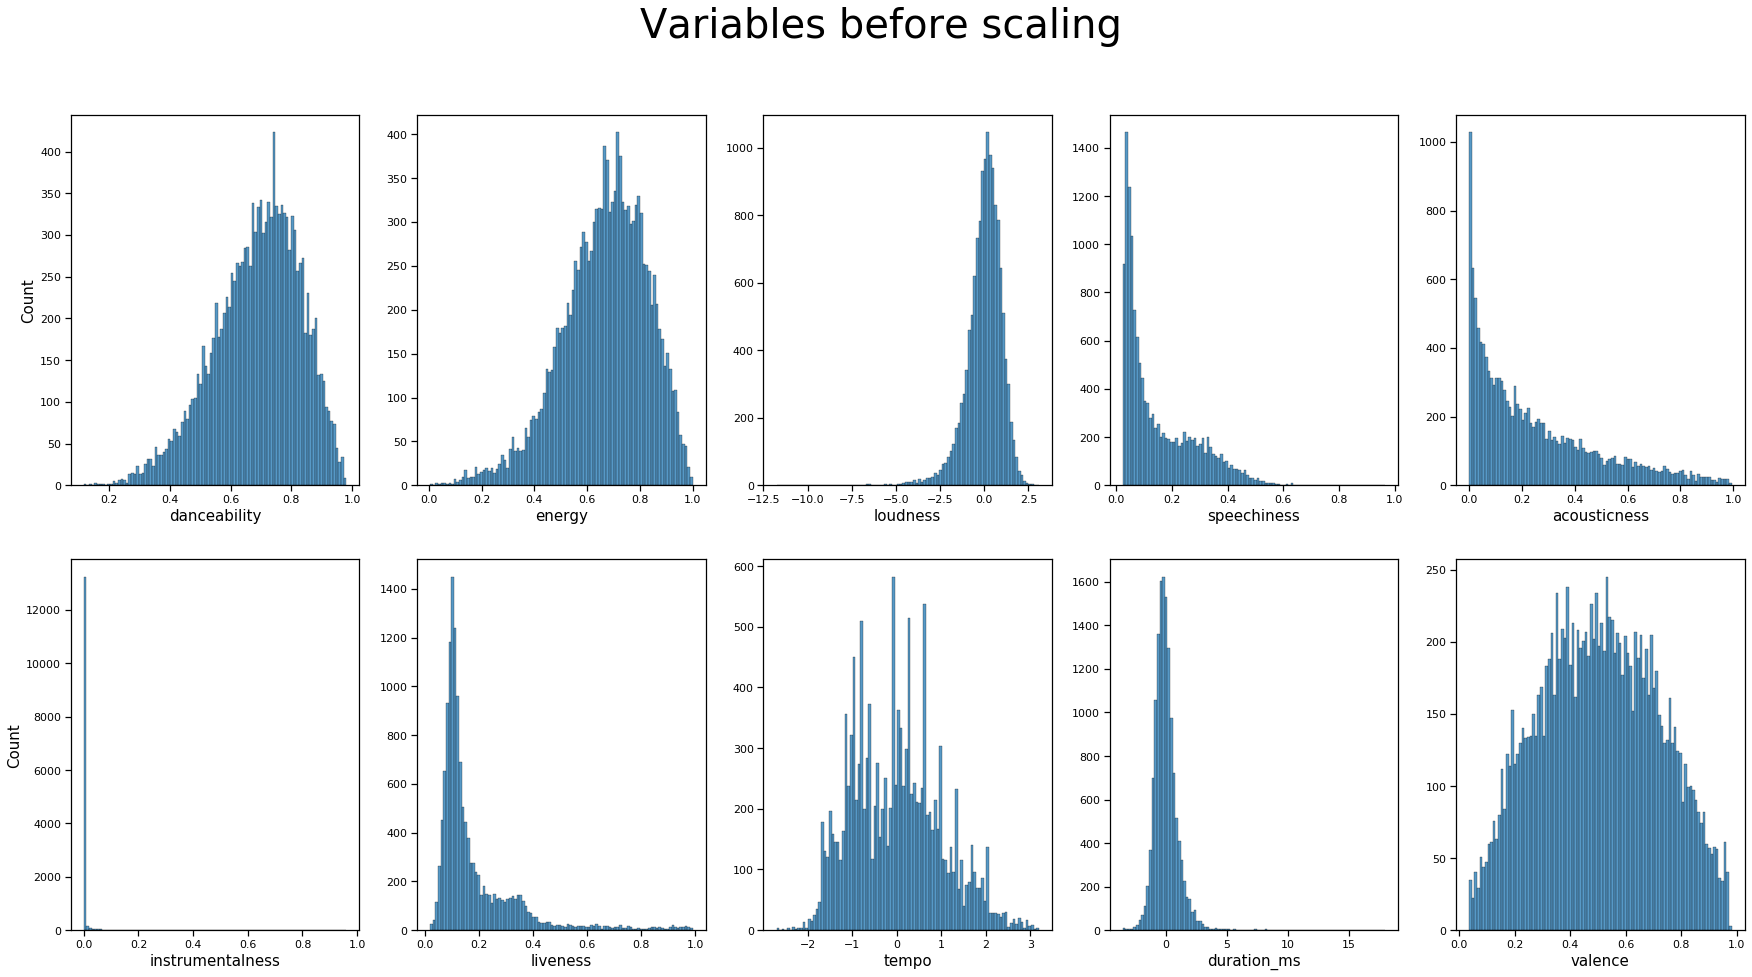

In [191]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":30,"axes.labelsize":15})  

# Create columns iterator
numerical = df.loc[:, ~df.columns.isin(('key',	'mode',	'time_signature'))].columns
lst = iter(numerical)

# Create histograms
fig, axes = plt.subplots(2, 5, figsize=(30, 15))


for triaxis in axes:
    for i, axis in enumerate(triaxis):
        try:
            b = sns.histplot(data = df, x=df[next(lst)], bins = 100, ax=axis)
            if i != 0:
                b.set_ylabel(None)
        except IndexError:
            break

fig.suptitle('Variables before scaling', fontsize=40)

_ = sns.reset_orig        

* Based on the info presented above we need to perform the following pre-poscessing steps:
1. Normalize numeric columns (['Loudness', 'Tempo']) 
2. One hot encode categorical columns* (['Key', 'Time Signature'])

\* 'Mode' is not mentioned since it already takes binary values

In [177]:
# standardize numeric columns by calculating the z-score of each value.
scaler = StandardScaler()
df[['loudness', 'tempo', 'duration_ms']] = scaler.fit_transform(df[['loudness', 'tempo', 'duration_ms']].to_numpy())

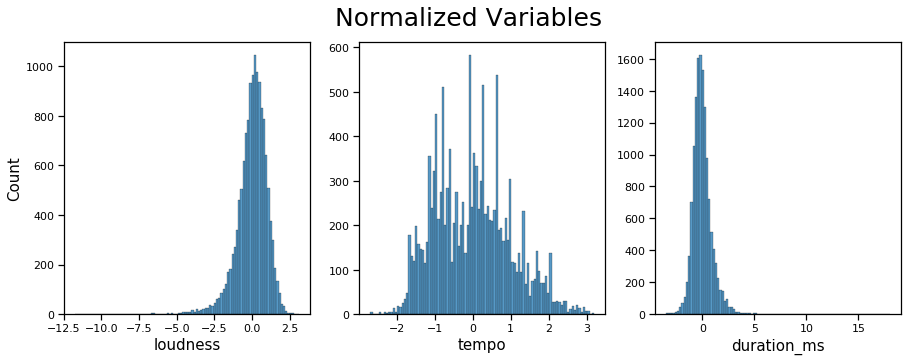

In [190]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":30,"axes.labelsize":15})  

# Create columns iterator
log_numerical = df.loc[:, df.columns.isin(('loudness', 'tempo', 'duration_ms'))].columns
lst = iter(log_numerical)

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


for i, axis in enumerate(axes):
    try:
        b = sns.histplot(data = df, x=df[next(lst)], bins = 100, ax=axis)
        if i != 0:
            b.set_ylabel(None)
    except IndexError:
        break

fig.suptitle('Standardize Variables', fontsize=25)

_ = sns.reset_orig   

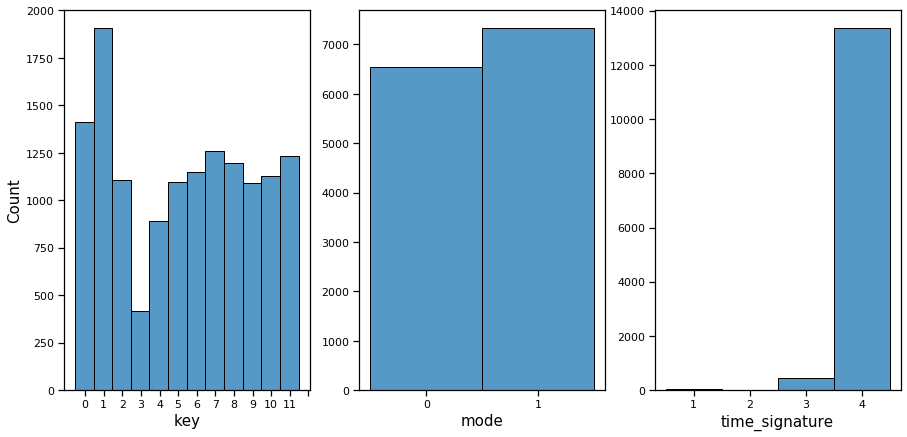

In [188]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":15})  

# Create columns iterator
categorical = df.loc[:, df.columns.isin(('key',	'mode',	'time_signature'))].columns
lst = iter(categorical)

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 7))


for i, axis in enumerate(axes):
    try:
        col = next(lst)
        bin_num = len(df[col].value_counts())
        b = sns.histplot(data = df, x=col, bins=bin_num, ax=axis)
        
        # fix bin position
        if col == 'time_signature':
            
            b.set_xticks(np.arange(df[col].value_counts().keys().min()+0.5,bin_num+1, 1))
            b.set_xticklabels(np.arange(df[col].value_counts().keys().min(),bin_num+1, 1))
        elif col == 'key':
            b.set_xticks(np.arange(df[col].value_counts().keys().min()+0.5,bin_num, 0.915))
            b.set_xticklabels(np.arange(df[col].value_counts().keys().min(),bin_num, 1))
        else:
            b.set_xticks([0.25, 0.75])
            b.set_xticklabels([0,1])
        # keep only one 'count'
        if i != 0:
            b.set_ylabel(None)    
    except IndexError:
        break


_ = sns.reset_orig     

### One hot encode

* We will now proceed with one-hot encoding the categorical variables. The originl dataframe (df) will be kept intact, since the one hot encoding we will prerform here will be different than the one needed for the ML part (prediction).
* As a rule of thumb, when running Regression models and search for statistical significance, a categorical variable with $n$ distinct values will

In [199]:
list([f"C({col})"df.columns[-4:-1])

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'tempo',
 'duration_ms',
 'key']

In [196]:
all_columns = list(df.columns[:-4])
all_columns_formula = f"valence ~ " + '+'.join(all_columns)
df_mod = smf.ols(all_columns_formula, data=df)
df_res = df_mod.fit()
df_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     357.4
Date:                Fri, 31 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:34:44   Log-Likelihood:                 3542.2
No. Observations:               13880   AIC:                            -7058.
Df Residuals:                   13867   BIC:                            -6960.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2241      0.025     -8.870      0.000      -0.274      -0.175
danceability         0.3997      0.012     33.271      0.000       0.376       0.423
energy               0.6025      0.015     39.441      0.000       0.573       0.632
loudness            -0.0057      0.002     -2.350      0.019      -0.010      -0.001
speechiness         -0.1173      0.013     -9.302      0.000      -0.142      -0.093
acousticness         0.1734      0.008     22.446      0.000       0.158       0.189
instrumentalness    -0.1587      0.027     -5.929      0.000      -0.211      -0.106
liveness             0.0487      0.011      4.538      0.000       0.028       0.070
tempo                0.0064      0.002      3.996      0.000       0.003       0.010
duration_ms         -0.0145      0.002     -8.861      0.000      -0.018      -0.011
key                  0.0022      0.000      4.847      0.000       0.001       0.003
mode                 0.0054      0.003      1.634      0.102      -0.001       0.012
time_signature       0.0012      0.005      0.218      0.827      -0.009       0.012
==============================================================================
Omnibus:                      141.030   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.882
Skew:                           0.014   Prob(JB):                     3.04e-20
Kurtosis:                       2.607   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Section 2: Predict Valence

We will use Machine Learning techniques to predict valence based on track features. Rules:

* Use at least three different methods. For each method, ensure thatthe hyperparameters are tunes to the best result possible.

* Once the best method and hyperparameters are identified, explain, to the extent that is possible, which features influence the valence metric.

* Evaluate predictions on a holdout 20% testing dataset.